In [1]:
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt
from urllib.parse import urlparse
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer

pd.options.mode.chained_assignment = None  # default='warn'

## Wczytanie zbioru COAID

Dataset CoAID składa się ze dwóch zbiorów, w których kolejno znajdują się newsy skategoryzowane jako "true" oraz "fake". Dodatkowo każdy z tych zbiorów podzielony jest na 4 podzbiory, które różnią się datą ich zebrania. W sumie należy połączyć 8 podzbiorów w jeden wspólny zbiór, na którym przeprowadzona zostanie analiza oraz modelowanie.

In [2]:
#Zbior
df1_true = pd.read_csv('data/05-01-2020/NewsRealCOVID-19.csv')
df2_true = pd.read_csv('data/07-01-2020/NewsRealCOVID-19.csv')
df3_true = pd.read_csv('data/09-01-2020/NewsRealCOVID-19.csv')
df4_true = pd.read_csv('data/11-01-2020/NewsRealCOVID-19.csv')

df1_fake = pd.read_csv('data/05-01-2020/NewsFakeCOVID-19.csv')
df2_fake = pd.read_csv('data/07-01-2020/NewsFakeCOVID-19.csv')
df3_fake = pd.read_csv('data/09-01-2020/NewsFakeCOVID-19.csv')
df4_fake = pd.read_csv('data/11-01-2020/NewsFakeCOVID-19.csv')

df_true = pd.concat([df1_true, df2_true, df3_true, df4_true])
df_true['label'] = 'true'

df_fake = pd.concat([df1_fake, df2_fake, df3_fake, df4_fake])
df_fake['label'] = 'fake'

print("---------------------")
print("Wiersze df_true:", df_true.shape[0])
print("Kolumny df_true:", df_true.shape[1])
print("---------------- ----")
print("Wiersze df_fake:", df_fake.shape[0])
print("Kolumny df_fake:", df_fake.shape[1])
print("---------------- ----")
print("Razem wierszy:  ", df_true.shape[0]+df_fake.shape[0])
print("---------------------")

---------------------
Wiersze df_true: 4532
Kolumny df_true: 11
---------------- ----
Wiersze df_fake: 925
Kolumny df_fake: 16
---------------- ----
Razem wierszy:   5457
---------------------


Pomimo różnic w liczbie kolumn w obu podzbiorach, można je bez problemu połączyć w jeden zbiór. W przypadku df_true dodatkowe kolumny wypełnią się pustymi wartościami - NaN.

In [3]:
df_all = pd.concat([df_true, df_fake])
df_all.sample(5)

,Unnamed: 0,type,fact_check_url,news_url,title,newstitle,content,abstract,publish_date,meta_keywords,label,archieve,news_url2,news_url3,news_url4,news_url5
346,3004,article,webmd.com,https://www.webmd.com/lung/news/20200826/ameri...,American Girl Honors Front-Line Heroes,"""Access denied | www.webmd.com used Cloudflare...",this website is using security service to prot...,NaN,NaN,"""""",true,NaN,NaN,NaN,NaN,NaN
304,1859,article,medicalnewstoday.com,https://www.medicalnewstoday.com/articles/a-no...,'A no-win situation' — Expert weighs in on COV...,"""‘A no-win situation’ — Expert weighs in on CO...",the current pandemic is exposing and exacerbat...,those of us who work in the health disparities...,NaN,"""""",true,NaN,NaN,NaN,NaN,NaN
1080,1080,article,webmd.com,https://www.webmd.com/lung/news/20200320/covid...,"COVID-19 Daily: Topol Laments Betrayal, HCP Co...","""COVID-19 Daily: Topol Laments Betrayal, HCP C...",here are the coronavirus stories medscape 's e...,these are the coronavirus stories you need to ...,NaN,"""infection control,infection in the immunocomp...",true,NaN,NaN,NaN,NaN,NaN
183,806,post,https://leadstories.com/hoax-alert/2020/05/pen...,https://www.facebook.com/photo.php?fbid=101581...,Pennsylvania’s governor breaking his own socia...,"""Diane Bianchi""",see more of diane bianchi on facebook.,this is the governor that says we ca nt reopen...,NaN,"""""",fake,https://web.archive.org/web/20200513152022/htt...,NaN,NaN,NaN,NaN
849,849,article,webmd.com,https://www.webmd.com/lung/news/20200327/cdc-s...,CDC: Separate Moms With Coronavirus From Newborns,"""CDC: Separate Moms With Coronavirus From Newb...",march 27 2020 -- the cdc has heartbreaking adv...,the recommendation also applies to new moms in...,NaN,"""coronavirus, covid-19, cdc, maternity ward, n...",true,NaN,NaN,NaN,NaN,NaN


In [4]:
# Ograniczenie zbioru do 8 najważniejszych kolumn

df_all = df_all[['label', 'type', 'fact_check_url', 'news_url', 
                 'title', 'newstitle', 'content', 'abstract']]

W zbiorze danych występuje wiele obserwacji, które nie przechowują żadnej wartości w kolumnie "content", która jest najbardziej istotna dla naszych badań. Należy je usunąć.

In [5]:
nan = df_all['content'].isnull().sum(axis = 0)
print("Liczba NaN w kolumnie 'content':",(nan))
df_all = df_all[df_all['content'].notna()]

print("Liczba NaN w kolumnie 'content' po operacji:",(df_all['content'].isnull().sum(axis = 0)))
print("Liczba wierszy po operacji:", len(df_all))

Liczba NaN w kolumnie 'content': 1017
Liczba NaN w kolumnie 'content' po operacji: 0
Liczba wierszy po operacji: 4440


Kolejnym problemem są występujące w zbiorze duplikaty. Zanim zostaną usunięte przyjrzyjmy się tym, które występują w zbiorze najczęściej.

In [6]:
# 15 najczęstszych duplikatów dla true
pd.DataFrame(df_true['content'].value_counts()[1:15]).rename_axis('text')

,content
text,
this website is using a security service to protect itself from online attacks ..,352
centers for disease control and prevention. cdc twenty four seven. saving lives protecting people centers for disease control and prevention. cdc twenty four seven. saving lives protecting people.,79
centers for disease control and prevention. cdc twenty four seven. saving lives protecting people.,10
content describing non cdc tools on this site is provided for informational purposes only and is not intended to indicate endorsement actual or implied of the tools. additionally information on this site is provided as is for users to evaluate and make their own determination as to their effectiveness.,9
we 've detected that javascript is disabled in your browser. would you like to proceed to legacy twitter.,8
i think or know i had covid-19 and i had symptoms. when can i be with others.,4
experts warn most states that are reopening still are nt doing enough testing as more u.s. states start to loosen stay at home orders experts warn that covid-19 could come back if there s not enough testing. according to the associated press a significant number of states that are reopening are still not meeting key testing benchmarks suggested by harvards global health institute. according to the institute and the world health organization who there should be enough testing done that the.,4
coronavirus disease 2019 covid-19 is a respiratory illness caused by a virus called sars cov-2. symptoms often include cough shortness of breath fever chills muscle pain sore throat or new loss of taste or smell. our understanding of how the virus spreads is evolving as we learn more about it so check the cdc website for the latest information. the virus is thought to spread mainly from person to person between people who are in close contact with one another within about 6 feet.,3
experts say biology as well as behavior may be among the reasons more men than women are developing covid-19 and dying from the disease. getty images several studies have shown that more men are dying from covid-19 than women. experts say part of the reason is women tend to have stronger immune systems than men. they add that men also tend to engage in more risky behavior such as ignoring physical distancing and they do nt take symptoms as seriously. all data and statistics are based on p.,3


In [7]:
# 15 najczęstszych duplikatów dla fake
pd.DataFrame(df_fake['content'].value_counts()[1:15]).rename_axis('text')

,content
text,
you must log in to continue ..,20
we 've detected that javascript is disabled in your browser. would you like to proceed to legacy twitter.,19
join this group to post and comment ..,5
it may be time to show us what your scalp and edges really look like ladies. word on the street is that hair weave and lace fronts manufactured in china may contain the coronavirus. the centers for disease control and prevention cdc is closely monitoring an outbreak of respiratory illness caused by a novel new coronavirus first identified in wuhan hubei province china. chinese authorities identified the new coronavirus which has resulted in thousands of confirmed cases in china includi.,4
the controversial ethiopian politician and director general of the world health organization who claimed in a press conference in early march that the fatality rate for the coronavirus was many multiples that of the fatality rate of the common flu. this egregiously false premise has led to the greatest panic in world history. the director general of the who spoke on march 3 2020 and shared this related to the coronavirus while many people globally have built up immunity to seasonal flu.,3
elisa granato the first volunteer who availed herself in oxford for a jab in the first europe human trial of a vaccine to protect against the coronavirus pandemic has died. she died two days after the vaccine was administered authorities have said and added that an investigation into the cause of the death has been initiated. a statement by the researchers said elisa had complications few hours after taking the vaccine and died while on admission. elisa granato who is a scientist was one.,3
see more of randall thompson on facebook.,3
omns january 26 2020 the coronavirus pandemic can be dramatically slowed or stopped with the immediate widespread use of high doses of vitamin c. physicians have demonstrated the powerful antiviral action of vitamin c for decades. there has been a lack of media coverage of this effective and successful approach against viruses in general and coronavirus in particular. it is very important to maximize the bodys anti oxidative capacity and natural immunity to prevent and minimize symptoms.,3
update 1040et science moves fast during an outbreak like this and dr. feigl ding has issued a few tweets clarifying and correcting some of the information cited in the threads we included below. though beforehand he acknowledged that the paper conclusions are bat shit wild and need to be scrutinized by the scientific community immediately. the situation is fluid. who knows what researchers will discover next. over the past few days the mainstream press has vigorously pushed back agai.,2


Widzimy, że w wielu obserwacjach zbioru CoAID scrapping tekstu z artykułów się nie powiódł. Przyczynami takiego stanu rzeczy mogły być zabezpieczenia na stronie, wymóg zalogowania się lub też usunięty artykuł. Zdarzyły się też newsy, których treść powieliła się. Pozostaje nam usunięcie duplikatów, aby nie zaburzać obiektywności uczonych później modeli.

In [8]:
unique = df_all['content'].nunique()
print("Liczba duplikatów:",(len(df_true) - unique))

# usunięcie duplikatów (kolumna 'content')
df_all = df_all.drop_duplicates(subset='content', keep="last")

#liczba duplikatów
print("Liczba duplikatów po operacji:",(len(df_all['content']) - df_all['content'].nunique()))
print("Liczba wierszy po operacji:", len(df_all))

Liczba duplikatów: 1457
Liczba duplikatów po operacji: 0
Liczba wierszy po operacji: 3075


Pomimo usunięcia duplikatów, wciąż pozostały pojedyncze obserwacje zawierające teksty, które nie dotyczą artykułów. Widać między innymi kilka obserwacji, które podczas scrapingu pobrały frazę "see more of ... on facebook". W następnym kroku należy usunąć te i inne obserwacje zawierające zbędne teksty. 

Liczba true po operacji: 2737
Liczba false po operacji: 200
Liczba wszystkich wierszy po operacji: 2937


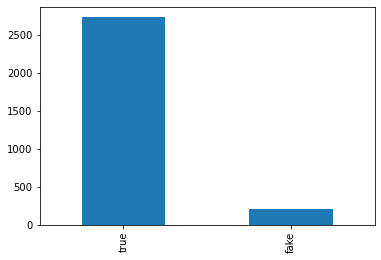

In [9]:
df_all = df_all[~df_all.content.str.contains("do you want to join facebook")]
df_all = df_all[~df_all.content.str.contains("see more of")]
df_all = df_all[~df_all.content.str.contains("this is not the page you 're looking for")]
df_all = df_all[~df_all.content.str.contains("you must log in to continue")]
df_all = df_all[~df_all.content.str.contains("please wait few minutes before you try again")]
df_all = df_all[~df_all.content.str.contains("this browser is no longer supported")]
df_all = df_all[~df_all.content.str.contains("detected that javascript is disabled in your browser")]

print("Liczba true po operacji:", len(df_all[(df_all['label']=='true')]))
print("Liczba false po operacji:", len(df_all[(df_all['label']=='fake')]))
print("Liczba wszystkich wierszy po operacji:", len(df_all))

df_all['label'].value_counts(normalize=False).plot(kind='bar');

### Analiza źródeł danych

Kolumna 'news_url' przechowuje linki do artykułów, z których można wyciągnąć same nazwy domen. W ten sposób możemy policzyć liczbę artykułów od danej organizacji lub wydawcy. Warto sprawdzić to dla obu etykiet.

In [10]:
#True
df_all['publisher_site'] = df_all['news_url'].apply(lambda x: urlparse(x).netloc).apply(lambda x: x.removeprefix('www.'))
df_all['publisher_site'][df_all.label == 'true'].value_counts()[1:15]

webmd.com                  627
healthline.com             561
medicalnewstoday.com       456
who.int                    158
nih.gov                     74
transcripts.cnn.com          3
facebook.com                 3
abcnews.go.com               2
wral.com                     2
medium.com                   2
newsradiowrva.radio.com      1
jsonline.com                 1
covid.cdc.gov                1
pets.webmd.com               1
Name: publisher_site, dtype: int64

In [11]:
#Fake
df_all['publisher_site'] = df_all['news_url'].apply(lambda x: urlparse(x).netloc).apply(lambda x: x.removeprefix('www.'))
df_all['publisher_site'][df_all.label == 'fake'].value_counts()[1:15]

whitehouse.gov              7
naturalnews.com             4
rev.com                     4
factba.se                   3
cnbc.com                    3
mcmnt.com                   3
transcripts.cnn.com         2
cbsnews.com                 2
worldnewsdailyreport.com    2
globalresearch.ca           2
intellihub.com              2
ucrtv.com                   2
viralcocaine.com            2
thegatewaypundit.com        2
Name: publisher_site, dtype: int64

Ciekawą rzeczą jest pojawienie się w zbiorze 7 newsów oznaczonych etykietą "fake", które pochodzą z domeny whitehouse.gov. Można to zbadać.

In [12]:
# Pokażmy 20 najczęściej występujących Tokenów oraz liczbę ich wystąpień w Korpusie

tokens_set = set()
df_all['content'].str.split(" ").map(tokens_set.update)

cntr = Counter()
df_all["content"].str.split(" ").map(cntr.update)

print("---------------------")
print("Wszystkich tokenów: ", len(tokens_set))
print("---------------------")
print("Najczęściej występujące tokeny i liczba ich powtórzeń:")

cntr.most_common(n=20)

---------------------
Wszystkich tokenów:  15549
---------------------
Najczęściej występujące tokeny i liczba ich powtórzeń:


[('the', 8234),
 ('and', 6725),
 ('of', 6618),
 ('to', 6011),
 ('in', 3878),
 ('', 2937),
 ('a', 2811),
 ('covid-19', 2782),
 ('for', 2735),
 ('are', 2431),
 ('is', 2399),
 ('on', 2390),
 ('that', 2230),
 ('with', 2040),
 ('at', 1488),
 ('as', 1471),
 ('be', 1421),
 ('have', 1299),
 ('coronavirus', 1278),
 ('people', 1170)]

In [13]:
# Możemy zliczyć sumę wystąpień poszczególnych Tokenów w każdym Dokumencie i zapisać to w dodatkowej kolumnie. 
# Dzięki temu powstał uproszczony Bag of Words dla każdego dokumentu.
df_all['text_norm'] = df_all['content'].str.lower()
df_all["text_norm_counter"] = df_all["text_norm"].str.split(" ").map(lambda x: dict(Counter(x)) )
df_all["counter_tokens"] = df_all["text_norm_counter"].map(lambda x: sum(x.values()) )

In [14]:
# Zapisanie nowego zbioru danych do formatów: .csv oraz .xlsx

df_all.to_csv('../coaid_dataset.csv', encoding='utf-8', index=False)
df_all.to_excel('../coaid_dataset.xlsx')

## Claims - stwierdzenia i tezy na temat COVID-19

Oprócz samych newsów, zbiór COAID zawiera tabele "claims", które najczęściej przybierają postać jednozdaniowych stwierdzeń. Stwierdzenia te zawierają powszechne fakty i mity na temat koronawirusa, dzięki czemu dostarczą zbiorom uczącym wartościowych informacji. Efektem tego zabiegu powinna być lepsza jakość trenowanych modeli.

In [15]:
# Wczytanie zbioru
df1_true = pd.read_csv('data/05-01-2020/ClaimRealCOVID-19.csv')
df2_true = pd.read_csv('data/07-01-2020/ClaimRealCOVID-19.csv')
df3_true = pd.read_csv('data/09-01-2020/ClaimRealCOVID-19.csv')
df4_true = pd.read_csv('data/11-01-2020/ClaimRealCOVID-19.csv')

df1_fake = pd.read_csv('data/05-01-2020/ClaimFakeCOVID-19.csv')
df2_fake = pd.read_csv('data/07-01-2020/ClaimFakeCOVID-19.csv')


df_true = pd.concat([df1_true, df2_true, df3_true, df4_true])
df_true['label'] = 'true'

df_fake = pd.concat([df1_fake, df2_fake])
df_fake['label'] = 'fake'

print("---------------------")
print("Wiersze df_true:", df_true.shape[0])
print("Kolumny df_true:", df_true.shape[1])
print("---------------- ----")
print("Wiersze df_fake:", df_fake.shape[0])
print("Kolumny df_fake:", df_fake.shape[1])
print("---------------- ----")
print("Razem wierszy:  ", df_true.shape[0]+df_fake.shape[0])
print("---------------------")

---------------------
Wiersze df_true: 490
Kolumny df_true: 5
---------------- ----
Wiersze df_fake: 28
Kolumny df_fake: 5
---------------- ----
Razem wierszy:   518
---------------------


In [16]:
df_claims = pd.concat([df_true, df_fake])
df_claims.sample(5)

,Unnamed: 0,fact_check_url,news_url,title,label
33,100033,who.int,https://www.who.int/news-room/q-a-detail/q-a-c...,"""Is there anything I should not do?""",true
30,100196,who.int,https://www.who.int/emergencies/diseases/novel...,What is an immunity passport or a risk-free ce...,true
165,100165,who.int,https://www.who.int/emergencies/diseases/novel...,"""Are there any specific medicines to prevent o...",true
33,100371,who.int,https://www.who.int/emergencies/diseases/novel...,Can adding pepper to your soup or other meals ...,true
153,100153,who.int,https://www.who.int/emergencies/diseases/novel...,"""COVID-19 virus can be transmitted in areas wi...",true


In [17]:
df_true['title'][144].values

array(['"Adding pepper to your soup or other meals DOES NOT prevent or cure COVID-19"',
       'How many API suppliers are there?'], dtype=object)

In [18]:
# Usunięcie claimów, które miały pytajniki w tekście
df_claims = df_claims[~df_claims['title'].str.contains("?", regex=False)]

In [19]:
# Lista stwierdzeń/tez z etykietą 'true'
df_claims['title'][df_claims['label']=='true'].values

array(['"There are currently no drugs licensed for the treatment or prevention of COVID-19"',
       '"Adding pepper to your soup or other meals DOES NOT prevent or cure COVID-19"',
       '"COVID-19 IS NOT transmitted through houseflies"',
       '"Spraying and introducing bleach or another disinfectant into your body WILL NOT protect you against COVID-19 and can be dangerous"',
       '"Drinking methanol, ethanol or bleach DOES NOT prevent or cure COVID-19 and can be extremely dangerous"',
       '"5G mobile networks DO NOT spread COVID-19"',
       '"Exposing yourself to the sun or to temperatures higher than 25C degrees DOES NOT prevent the coronavirus disease (COVID-19)"',
       '"You can recover from the coronavirus disease (COVID-19). Catching the new coronavirus DOES NOT mean you will have it for life."',
       '"Being able to hold your breath for 10 seconds or more without coughing or feeling discomfort DOES NOT mean you are free from the coronavirus disease (COVID-19) or an

In [20]:
# Lista stwierdzeń/tez z etykietą 'fake'
df_claims['title'][df_claims['label']=='fake'].values

array(['"Spraying chlorine or alcohol on the skin kills viruses in the body"',
       '"Only older adults and young people are at risk"',
       '"Children cannot get COVID-19"',
       '"COVID-19 is just like the flu"', '"Everyone with COVID-19 dies"',
       '"Cats and dogs spread coronavirus"',
       '"Face masks always protect against coronavirus"',
       '"Hand dryers kill coronavirus"',
       '"SARS-CoV-2 is just a mutated form of the common cold"',
       '"You have to be with someone for 10 minutes to catch the virus"',
       '"Rinsing the nose with saline protects against coronavirus"',
       '"You can protect yourself by gargling bleach"',
       '"Antibiotics kill coronavirus"',
       '"Thermal scanners can diagnose coronavirus"',
       '"Garlic protects against coronaviruses"',
       '"Parcels from China can spread coronavirus"',
       '"Home remedies can cure and protect against COVID-19"',
       '"You can catch coronavirus from eating Chinese food in the US"',
 

In [21]:
# Usunięcie tekstów, które nie są stwierdzeniami na temat COVID-19
df_claims = df_claims[~df_claims['title'].str.contains("Checklist for parents/caregivers and community members")]
df_claims = df_claims[~df_claims['title'].str.contains("Checklist for students and children")]

In [22]:
print("---------------------")
print("Liczba claim: ", df_claims.shape[0])
print("---------------------")

---------------------
Liczba claim:  66
---------------------


In [23]:
# Redukcja tabeli do niezbędnych kolumn
df_claims['text'] = df_claims['title']
df_claims['target'] = df_claims['label']
df_claims = df_claims[['target', 'text']]
df_claims = df_claims.reset_index()
df_claims.drop(['index'], axis=1, inplace=True)
df_claims

,target,text
0,true,"""There are currently no drugs licensed for the..."
1,true,"""Adding pepper to your soup or other meals DOE..."
2,true,"""COVID-19 IS NOT transmitted through houseflies"""
3,true,"""Spraying and introducing bleach or another di..."
4,true,"""Drinking methanol, ethanol or bleach DOES NOT..."
...,...,...
61,fake,"""The outbreak began because people ate bat soup"""
62,fake,"""5G helps SARS-CoV-2 spread"""
63,fake,"""Drinking alcohol reduces the risk of infection"""
64,fake,"""Injecting or consuming bleach or disinfectant..."


In [24]:
# Możemy zliczyć sumę wystąpień poszczególnych Tokenów w każdym Dokumencie
df_claims['text_norm'] = df_claims['text'].str.lower()
df_claims["text_norm_counter"] = df_claims["text_norm"].str.split(" ").map(lambda x: dict(Counter(x)) )
df_claims["counter_tokens"] = df_claims["text_norm_counter"].map(lambda x: sum(x.values()) )

In [25]:
df_claims.sample(5)

,target,text,text_norm,text_norm_counter,counter_tokens
9,true,"""Drinking alcohol does not protect you against...","""drinking alcohol does not protect you against...","{'""drinking': 1, 'alcohol': 1, 'does': 1, 'not...",12
5,true,"""5G mobile networks DO NOT spread COVID-19""","""5g mobile networks do not spread covid-19""","{'""5g': 1, 'mobile': 1, 'networks': 1, 'do': 1...",7
43,fake,"""Cats and dogs spread coronavirus""","""cats and dogs spread coronavirus""","{'""cats': 1, 'and': 1, 'dogs': 1, 'spread': 1,...",5
11,true,"""Cold weather and snow CANNOT kill the new cor...","""cold weather and snow cannot kill the new cor...","{'""cold': 1, 'weather': 1, 'and': 1, 'snow': 1...",9
26,true,Drinking methanol ethanol or bleach DOES NOT p...,drinking methanol ethanol or bleach does not p...,"{'drinking': 1, 'methanol': 1, 'ethanol': 1, '...",16


In [26]:
df_claims.to_csv('../coaid_claims.csv', encoding='utf-8', index=False)
df_claims.to_excel('../coaid_claims.xlsx')